In [1]:
import re
import numpy as np
import pandas as pd
import collections
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.cross_validation import train_test_split
from unidecode import unidecode
from nltk.util import ngrams
from tqdm import tqdm
import time

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
permulaan = [
    'bel',
    'se',
    'ter',
    'men',
    'meng',
    'mem',
    'memper',
    'di',
    'pe',
    'me',
    'ke',
    'ber',
    'pen',
    'per',
]

hujung = ['kan', 'kah', 'lah', 'tah', 'nya', 'an', 'wan', 'wati', 'ita']

def naive_stemmer(word):
    assert isinstance(word, str), 'input must be a string'
    hujung_result = re.findall(r'^(.*?)(%s)$' % ('|'.join(hujung)), word)
    word = hujung_result[0][0] if len(hujung_result) else word
    permulaan_result = re.findall(r'^(.*?)(%s)' % ('|'.join(permulaan[::-1])), word)
    permulaan_result.extend(re.findall(r'^(.*?)(%s)' % ('|'.join(permulaan)), word))
    mula = permulaan_result if len(permulaan_result) else ''
    if len(mula):
        mula = mula[1][1] if len(mula[1][1]) > len(mula[0][1]) else mula[0][1]
    return word.replace(mula, '')

In [3]:
def build_dataset(words, n_words):
    count = [['GO', 0], ['PAD', 1], ['EOS', 2], ['UNK', 3]]
    counter = collections.Counter(words).most_common(n_words)
    count.extend(counter)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 3)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary


def classification_textcleaning(string):
    string = re.sub(
        'http\S+|www.\S+',
        '',
        ' '.join(
            [i for i in string.split() if i.find('#') < 0 and i.find('@') < 0]
        ),
    )
    string = unidecode(string).replace('.', ' . ').replace(',', ' , ')
    string = re.sub('[^A-Za-z ]+', ' ', string)
    string = re.sub(r'[ ]+', ' ', string).strip()
    string = ' '.join(
        [i for i in re.findall('[\\w\']+|[;:\-\(\)&.,!?"]', string) if len(i)]
    )
    string = string.lower().split()
    string = [(naive_stemmer(word), word) for word in string]
    return (
        ' '.join([word[0] for word in string if len(word[0]) > 1]),
        ' '.join([word[1] for word in string if len(word[0]) > 1]),
    )

def str_idx(corpus, dic, maxlen, UNK = 3):
    X = np.zeros((len(corpus), maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i].split()[:maxlen][::-1]):
            val = dic[k] if k in dic else UNK
            X[i, -1 - no] = val
    return X

In [4]:
import os
emotion_files = [f for f in os.listdir(os.getcwd()) if 'translated-' in f]
emotion_files

['translated-joy',
 'translated-love',
 'translated-fear',
 'translated-sadness',
 'translated-surprise',
 'translated-anger']

In [5]:
texts, labels = [], []
for f in emotion_files:
    with open(f) as fopen:
        dataset = list(filter(None, fopen.read().split('\n')))
        labels.extend([f.split('-')[1]] * len(dataset))
        texts.extend(dataset)

In [6]:
for i in range(len(texts)):
    texts[i] = classification_textcleaning(texts[i])[0]

In [7]:
unique_labels = np.unique(labels).tolist()
labels = LabelEncoder().fit_transform(labels)
unique_labels

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [8]:
concat = ' '.join(texts).split()
vocabulary_size = len(list(set(concat)))
data, count, dictionary, rev_dictionary = build_dataset(concat, vocabulary_size)
print('vocab from size: %d'%(vocabulary_size))
print('Most common words', count[4:10])
print('Sample data', data[:10], [rev_dictionary[i] for i in data[:10]])

vocab from size: 14652
Most common words [('saya', 165182), ('asa', 50903), ('rasa', 50028), ('tidak', 33044), ('yang', 31373), ('untuk', 15327)]
Sample data [520, 1152, 8, 4, 103, 719, 8, 94, 114, 8] ['buah', 'parti', 'yang', 'saya', 'gi', 'natal', 'yang', 'akhir', 'malam', 'yang']


In [9]:
def attention(inputs, attention_size):
    hidden_size = inputs.shape[2].value
    w_omega = tf.Variable(
        tf.random_normal([hidden_size, attention_size], stddev = 0.1)
    )
    b_omega = tf.Variable(tf.random_normal([attention_size], stddev = 0.1))
    u_omega = tf.Variable(tf.random_normal([attention_size], stddev = 0.1))
    with tf.name_scope('v'):
        v = tf.tanh(tf.tensordot(inputs, w_omega, axes = 1) + b_omega)
    vu = tf.tensordot(v, u_omega, axes = 1, name = 'vu')
    alphas = tf.nn.softmax(vu, name = 'alphas')
    output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), 1)
    return output, alphas


class Model:
    def __init__(
        self,
        size_layer,
        num_layers,
        dimension_output,
        learning_rate,
        dropout,
        dict_size,
    ):
        def cells(size, reuse = False):
            return tf.contrib.rnn.DropoutWrapper(
                tf.nn.rnn_cell.LSTMCell(
                    size,
                    initializer = tf.orthogonal_initializer(),
                    reuse = reuse,
                ),
                state_keep_prob = dropout,
                output_keep_prob = dropout,
            )

        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None])
        encoder_embeddings = tf.Variable(
            tf.random_uniform([dict_size, size_layer], -1, 1)
        )
        encoder_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.X)

        for n in range(num_layers):
            (out_fw, out_bw), (
                state_fw,
                state_bw,
            ) = tf.nn.bidirectional_dynamic_rnn(
                cell_fw = cells(size_layer),
                cell_bw = cells(size_layer),
                inputs = encoder_embedded,
                dtype = tf.float32,
                scope = 'bidirectional_rnn_%d' % (n),
            )
            encoder_embedded = tf.concat((out_fw, out_bw), 2)
        self.outputs, self.attention = attention(encoder_embedded, size_layer)
        W = tf.get_variable(
            'w',
            shape = (size_layer * 2, dimension_output),
            initializer = tf.orthogonal_initializer(),
        )
        b = tf.get_variable(
            'b', shape = (dimension_output), initializer = tf.zeros_initializer()
        )
        self.logits = tf.add(tf.matmul(self.outputs, W), b, name = 'logits')
        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = self.logits, labels = self.Y
            )
        )
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.cost)
        self.accuracy = tf.reduce_mean(
            tf.cast(tf.nn.in_top_k(self.logits, self.Y, 1), tf.float32)
        )

In [10]:
size_layer = 256
num_layers = 2
dimension_output = len(unique_labels)
learning_rate = 1e-4
batch_size = 32
dropout = 0.8
maxlen = 80

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(
    size_layer,
    num_layers,
    dimension_output,
    learning_rate,
    dropout,
    len(dictionary),
)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'hierarchical/model.ckpt')

'hierarchical/model.ckpt'

In [11]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or 'logits' in n.name
        or 'alphas' in n.name)
        and 'Adam' not in n.name
        and 'beta' not in n.name
    ]
)

In [12]:
strings.split(',')

['Placeholder',
 'Placeholder_1',
 'Variable',
 'bidirectional_rnn_0/fw/lstm_cell/kernel',
 'bidirectional_rnn_0/fw/lstm_cell/bias',
 'bidirectional_rnn_0/bw/lstm_cell/kernel',
 'bidirectional_rnn_0/bw/lstm_cell/bias',
 'bidirectional_rnn_1/fw/lstm_cell/kernel',
 'bidirectional_rnn_1/fw/lstm_cell/bias',
 'bidirectional_rnn_1/bw/lstm_cell/kernel',
 'bidirectional_rnn_1/bw/lstm_cell/bias',
 'Variable_1',
 'Variable_2',
 'Variable_3',
 'alphas',
 'w',
 'b',
 'logits',
 'gradients/logits_grad/Shape',
 'gradients/logits_grad/Shape_1',
 'gradients/logits_grad/BroadcastGradientArgs',
 'gradients/logits_grad/Sum',
 'gradients/logits_grad/Reshape',
 'gradients/logits_grad/Sum_1',
 'gradients/logits_grad/Reshape_1',
 'gradients/logits_grad/tuple/group_deps',
 'gradients/logits_grad/tuple/control_dependency',
 'gradients/logits_grad/tuple/control_dependency_1',
 'gradients/alphas_grad/mul',
 'gradients/alphas_grad/Sum/reduction_indices',
 'gradients/alphas_grad/Sum',
 'gradients/alphas_grad/sub',

In [13]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(14656, 256) dtype=float32_ref>,
 <tf.Variable 'bidirectional_rnn_0/fw/lstm_cell/kernel:0' shape=(512, 1024) dtype=float32_ref>,
 <tf.Variable 'bidirectional_rnn_0/fw/lstm_cell/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'bidirectional_rnn_0/bw/lstm_cell/kernel:0' shape=(512, 1024) dtype=float32_ref>,
 <tf.Variable 'bidirectional_rnn_0/bw/lstm_cell/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'bidirectional_rnn_1/fw/lstm_cell/kernel:0' shape=(768, 1024) dtype=float32_ref>,
 <tf.Variable 'bidirectional_rnn_1/fw/lstm_cell/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'bidirectional_rnn_1/bw/lstm_cell/kernel:0' shape=(768, 1024) dtype=float32_ref>,
 <tf.Variable 'bidirectional_rnn_1/bw/lstm_cell/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(512, 256) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(256,) dtype=float32_ref>,


In [14]:
vectors = str_idx(texts, dictionary, maxlen)
train_X, test_X, train_Y, test_Y = train_test_split(
    vectors, labels, test_size = 0.2
)

In [15]:
from tqdm import tqdm
import time

EARLY_STOPPING, CURRENT_CHECKPOINT, CURRENT_ACC, EPOCH = 3, 0, 0, 0

while True:
    lasttime = time.time()
    if CURRENT_CHECKPOINT == EARLY_STOPPING:
        print('break epoch:%d\n' % (EPOCH))
        break

    train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        batch_x = train_X[i : min(i + batch_size, train_X.shape[0])]
        batch_y = train_Y[i : min(i + batch_size, train_X.shape[0])]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost, _ = sess.run(
            [model.accuracy, model.cost, model.optimizer],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        assert not np.isnan(cost)
        train_loss += cost
        train_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    pbar = tqdm(range(0, len(test_X), batch_size), desc = 'test minibatch loop')
    for i in pbar:
        batch_x = test_X[i : min(i + batch_size, test_X.shape[0])]
        batch_y = test_Y[i : min(i + batch_size, test_X.shape[0])]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost = sess.run(
            [model.accuracy, model.cost],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        test_loss += cost
        test_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    train_loss /= len(train_X) / batch_size
    train_acc /= len(train_X) / batch_size
    test_loss /= len(test_X) / batch_size
    test_acc /= len(test_X) / batch_size

    if test_acc > CURRENT_ACC:
        print(
            'epoch: %d, pass acc: %f, current acc: %f'
            % (EPOCH, CURRENT_ACC, test_acc)
        )
        CURRENT_ACC = test_acc
        CURRENT_CHECKPOINT = 0
    else:
        CURRENT_CHECKPOINT += 1

    print('time taken:', time.time() - lasttime)
    print(
        'epoch: %d, training loss: %f, training acc: %f, valid loss: %f, valid acc: %f\n'
        % (EPOCH, train_loss, train_acc, test_loss, test_acc)
    )
    EPOCH += 1


train minibatch loop:   0%|          | 0/2463 [00:00<?, ?it/s]

epoch: 0, pass acc: 0.000000, current acc: 0.744528
time taken: 990.0525584220886
epoch: 0, training loss: 1.013617, training acc: 0.621481, valid loss: 0.724763, valid acc: 0.744528



train minibatch loop:   0%|          | 0/2463 [00:00<?, ?it/s]

epoch: 1, pass acc: 0.744528, current acc: 0.776929
time taken: 989.2616293430328
epoch: 1, training loss: 0.643985, training acc: 0.770365, valid loss: 0.621073, valid acc: 0.776929



train minibatch loop:   0%|          | 1/2463 [00:00<07:27,  5.50it/s, accuracy=0.781, cost=0.529]

epoch: 2, pass acc: 0.776929, current acc: 0.792815
time taken: 743.1806058883667
epoch: 2, training loss: 0.548819, training acc: 0.801694, valid loss: 0.573367, valid acc: 0.792815



train minibatch loop:   0%|          | 1/2463 [00:00<07:25,  5.52it/s, accuracy=0.719, cost=0.472]

epoch: 3, pass acc: 0.792815, current acc: 0.797585
time taken: 489.4627466201782
epoch: 3, training loss: 0.491971, training acc: 0.820297, valid loss: 0.553868, valid acc: 0.797585



train minibatch loop:   0%|          | 1/2463 [00:00<07:29,  5.48it/s, accuracy=0.812, cost=0.323]

epoch: 4, pass acc: 0.797585, current acc: 0.805280
time taken: 489.93515634536743
epoch: 4, training loss: 0.449033, training acc: 0.834724, valid loss: 0.541336, valid acc: 0.805280



train minibatch loop:   0%|          | 1/2463 [00:00<07:29,  5.48it/s, accuracy=0.812, cost=0.289]

time taken: 489.83995604515076
epoch: 5, training loss: 0.415231, training acc: 0.845647, valid loss: 0.546488, valid acc: 0.804894



train minibatch loop:   0%|          | 1/2463 [00:00<07:26,  5.51it/s, accuracy=0.906, cost=0.194]

epoch: 6, pass acc: 0.805280, current acc: 0.806873
time taken: 489.79181599617004
epoch: 6, training loss: 0.386597, training acc: 0.854391, valid loss: 0.545160, valid acc: 0.806873



train minibatch loop:   0%|          | 1/2463 [00:00<07:28,  5.49it/s, accuracy=0.875, cost=0.221]

time taken: 489.9598548412323
epoch: 7, training loss: 0.358662, training acc: 0.863516, valid loss: 0.557189, valid acc: 0.803391



train minibatch loop:   0%|          | 1/2463 [00:00<07:28,  5.48it/s, accuracy=0.906, cost=0.179]

time taken: 489.9887034893036
epoch: 8, training loss: 0.334689, training acc: 0.871013, valid loss: 0.575575, valid acc: 0.801615



test minibatch loop: 100%|██████████| 616/616 [00:39<00:00, 15.68it/s, accuracy=0.913, cost=0.223] 

time taken: 489.9724955558777
epoch: 9, training loss: 0.311374, training acc: 0.878896, valid loss: 0.590699, valid acc: 0.803340

break epoch:10



In [16]:
real_Y, predict_Y = [], []

pbar = tqdm(
    range(0, len(test_X), batch_size), desc = 'validation minibatch loop'
)
for i in pbar:
    batch_x = test_X[i : min(i + batch_size, test_X.shape[0])]
    batch_y = test_Y[i : min(i + batch_size, test_X.shape[0])]
    predict_Y += np.argmax(
        sess.run(
            model.logits, feed_dict = {model.X: batch_x, model.Y: batch_y}
        ),
        1,
    ).tolist()
    real_Y += batch_y.tolist()

validation minibatch loop: 100%|██████████| 616/616 [00:38<00:00, 15.92it/s]


In [17]:
from sklearn import metrics
print(metrics.classification_report(real_Y, predict_Y, target_names = unique_labels))

             precision    recall  f1-score   support

      anger       0.81      0.79      0.80      3786
       fear       0.78      0.79      0.78      3754
        joy       0.81      0.82      0.82      3886
       love       0.85      0.84      0.85      3022
    sadness       0.76      0.80      0.78      3300
   surprise       0.81      0.75      0.78      1955

avg / total       0.80      0.80      0.80     19703



In [18]:
text = classification_textcleaning('kerajaan sebenarnya sangat sayangkan rakyatnya, tetapi sebenarnya benci')
new_vector = str_idx([text[0]], dictionary, len(text[0].split()))
sess.run(tf.nn.softmax(model.logits), feed_dict={model.X:new_vector})

array([[0.6929183 , 0.01992497, 0.00488248, 0.14316376, 0.04100657,
        0.09810386]], dtype=float32)

In [19]:
import json
with open('hierarchical-emotion.json','w') as fopen:
    fopen.write(json.dumps({'dictionary':dictionary,'reverse_dictionary':rev_dictionary}))

In [20]:
saver.save(sess, 'hierarchical/model.ckpt')

'hierarchical/model.ckpt'

In [21]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [22]:
freeze_graph('hierarchical', strings)

INFO:tensorflow:Restoring parameters from hierarchical/model.ckpt
INFO:tensorflow:Froze 14 variables.
INFO:tensorflow:Converted 14 variables to const ops.
756 ops in the final graph.


In [23]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [24]:
g = load_graph('hierarchical/frozen_model.pb')
x = g.get_tensor_by_name('import/Placeholder:0')
logits = g.get_tensor_by_name('import/logits:0')
alphas = g.get_tensor_by_name('import/alphas:0')
test_sess = tf.InteractiveSession(graph = g)
result = test_sess.run([logits, alphas], feed_dict = {x: new_vector})

/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [26]:
news_string = 'kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya'
text = classification_textcleaning(news_string)
new_vector = str_idx([text[0]], dictionary, len(text[0].split()))
result = test_sess.run([tf.nn.softmax(logits), alphas], feed_dict = {x: new_vector})

In [27]:
result[0]

array([[9.7175378e-01, 9.8732123e-03, 8.1190962e-04, 7.6460522e-03,
        2.7126304e-03, 7.2023878e-03]], dtype=float32)

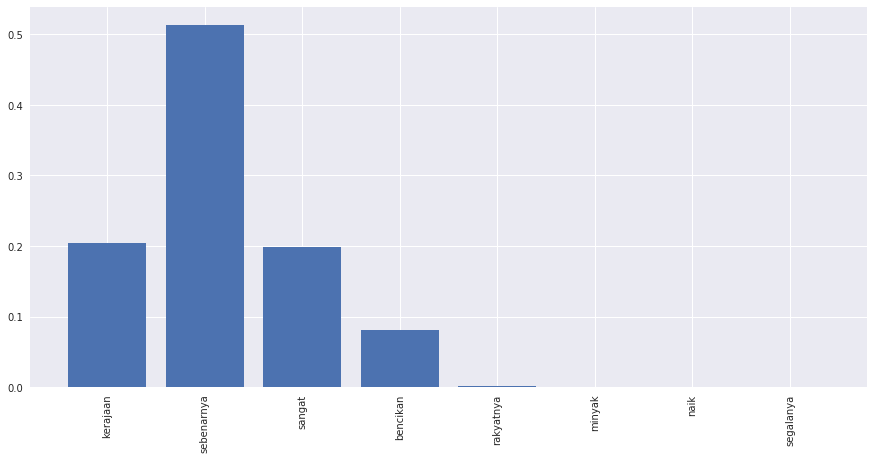

In [28]:
plt.figure(figsize = (15, 7))
labels = [word for word in text[1].split()]
val = [val for val in result[1][0]]
plt.bar(np.arange(len(labels)), val)
plt.xticks(np.arange(len(labels)), labels, rotation = 'vertical')
plt.show()